# Johdanto Datatieteeseen 2021 -practical work
### *author: Ilpo Viertola*
During this work, I've used [this Jupyter-notebook](https://www.kaggle.com/lunamcbride24/covid19-tweet-truth-analysis) as reference.

In [52]:
# Normal stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Twitter API
import tweepy
import ast

# Tweet preprocessing
import nltk
nltk.download('stopwords')  # Download stopwords (not downloaded if up to date)
nltk.download('wordnet')    # Download wordnet for lemmatizer (not downloaded if up to date)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import html
import string

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import SparseCategoricalCrossentropy #Loss function being used
from sklearn.model_selection import train_test_split #Train Test Split

# Describing the data
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from nltk import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilpoviertola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilpoviertola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the data
**Read the data in from [Kaggle csv-files](https://www.kaggle.com/elvinagammed/covid19-fake-news-dataset-nlp) and with Twitter API.**

In [53]:
csv_path = '/Users/ilpoviertola/OneDrive - TUNI.fi/Kurssimateriaaleja/JODA/datasets/covid19_fake_news'
# Data to train the model with
train_df = pd.read_csv(csv_path + '/Constraint_Train.csv')
train_df.head()
# Data to test the model with
test_df = pd.read_csv(csv_path + '/Constraint_Test.csv')
test_df.head()
# Data to validate the model with
val_df = pd.read_csv(csv_path + '/Constraint_Val.csv')
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


**Next Twitter data. First lets authenticate ourselves so we can use Twitter API.**

In [54]:
# Fetch Twitter API-keys from a local file.
key_file = open('twitter.key', 'r')
keys = ast.literal_eval(key_file.read())
key_file.close()

auth = tweepy.OAuthHandler(keys['API'], keys['API_secret'])
auth.set_access_token(keys['Access_token'], keys['Access_token_secret'])
api = tweepy.API(auth)

**Create DataFrame where the tweets are stored and fetch tweets.**

In [55]:
# Create DataFrame for tweets
tweet_df = pd.DataFrame(columns=['username', 'description', 'location', 'following', 'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'])

# Get tweets
hashtag = '#covid19'
d_since = '2021-04-07'
limit = 250
tweets = tweepy.Cursor(api.search, q=hashtag, lang='en', since=d_since, tweet_mode='extended').items(limit)
tweets_list = [tweet for tweet in tweets]

**Process tweets and add them to DataFrame. We'll exclude retweets.**

In [56]:
for tweet in tweets_list:
    # Data about tweets
    username = tweet.user.screen_name
    description = tweet.user.description
    location = tweet.user.location
    following = tweet.user.friends_count
    followers = tweet.user.followers_count
    totaltweets = tweet.user.statuses_count
    retweetcount = tweet.retweet_count
    hashtags = tweet.entities['hashtags']
    
    # Let's ignore all retweets
    if not tweet.retweeted and ('RT @' not in tweet.full_text):

        text = tweet.full_text
        hashtext = list()
        for j in range(0, len(hashtags)):
            hashtext.append(hashtags[j]['text'])
            
        # Lisätään data DataFrameen.
        ith_tweet = [username, description, location, following, followers, totaltweets, 
                    retweetcount, text, hashtext]
        tweet_df.loc[len(tweet_df)] = ith_tweet

tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc...",India,2935,2355,6252,0,"Chandigarh reports 431 new #COVID19 cases, tak...",[COVID19]
1,Koernerr,"Almost seventy, father, grandfather, educator,...","Deerfield, IL",548,226,9311,0,"Cold, Sunny, and Pandemically Affected https:/...","[confinement, covid19, coronavirus]"
2,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc...",India,2935,2355,6252,0,Jammu and Kashmir reports 1145 new #COVID19 po...,[COVID19]
3,News_Updates_24,For all the news updates follow news updates.,,262,24,1982,0,#Goa reports 762 new #COVID19 positive cases a...,"[Goa, COVID19]"
4,MrGladPortBlair,"Editor-in-Chief, Hawk Eye, English Daily, form...","Andaman Nicobar Islands, India",191,1853,20940,0,Ostriches of @Andaman_Admin report 1 more deat...,[COVID19]


## Data exploration
**Check column names**

In [57]:
print('Training & validation data\'s columns:')
print(train_df.columns.values)
print(val_df.columns.values)
print('Test data\'s columns:')
print(test_df.columns.values)
print('Twitter data\'s columns:')
print(tweet_df.columns.values)

Training & validation data's columns:
['id' 'tweet' 'label']
['id' 'tweet' 'label']
Test data's columns:
['id' 'tweet']
Twitter data's columns:
['username' 'description' 'location' 'following' 'followers' 'totaltweets'
 'retweetcount' 'text' 'hashtags']


**Columns are ok. Next check null-values and dataypes**

In [58]:
print('Null values in training data? ' + str(train_df.isnull().values.any()))
print('Null values in testing data? ' + str(test_df.isnull().values.any()))
print('Null values in validation data? ' + str(val_df.isnull().values.any()))
print('Null values in Twitter data? ' + str(tweet_df.isnull().values.any()))

Null values in training data? False
Null values in testing data? False
Null values in validation data? False
Null values in Twitter data? False


In [59]:
print('Datatypes for training data: \n' + str(train_df.dtypes) + '\n')
print('Datatypes for validation data: \n' + str(val_df.dtypes) + '\n')
print('Datatypes for testing data: \n' + str(test_df.dtypes) + '\n')
print('Datatypes for Twitter data: \n' + str(tweet_df.dtypes) + '\n')

Datatypes for training data: 
id        int64
tweet    object
label    object
dtype: object

Datatypes for validation data: 
id        int64
tweet    object
label    object
dtype: object

Datatypes for testing data: 
id        int64
tweet    object
dtype: object

Datatypes for Twitter data: 
username        object
description     object
location        object
following       object
followers       object
totaltweets     object
retweetcount    object
text            object
hashtags        object
dtype: object



**Twitter dataset needs some datatype modifications.**

In [60]:
tweet_df = tweet_df.astype({'following': 'int32', 'followers': 'int32', 
                            'totaltweets': 'int32', 'retweetcount': 'int32'})
print('New datatypes for Twitter data: \n' + str(tweet_df.dtypes) + '\n')

New datatypes for Twitter data: 
username        object
description     object
location        object
following        int32
followers        int32
totaltweets      int32
retweetcount     int32
text            object
hashtags        object
dtype: object



In [61]:
print('\nExample tweet from training data: ')
print(train_df['tweet'][5])
print('\nExample tweet from Twitter data: ')
print(tweet_df['text'][5])


Example tweet from training data: 
Covid Act Now found "on average each person in Illinois with COVID-19 is infecting 1.11 other people. Data shows that the infection growth rate has declined over time this factors in the stay-at-home order and other restrictions put in place." https://t.co/hhigDd24fE

Example tweet from Twitter data: 
"31 of Ontario's 44 municipal and regional police services have rejected the province's arbitrary detention and questioning powers"

Thank you for protecting our liberties Ontario Police!

@fordnation @RodPhillips01 @mayor_collier #covid19 #onhealth #onpoli #EndTheLockdowns https://t.co/uEFC7LFMBz


**Tweets typically contain links, other people's usernames, hashtags and emojis. These must be cleaned before training the model...**

In [62]:
print('Training data labels: \n', train_df['label'].value_counts())
print('\nValidation data labels: \n', val_df['label'].value_counts())

Training data labels: 
 real    3360
fake    3060
Name: label, dtype: int64

Validation data labels: 
 real    1120
fake    1020
Name: label, dtype: int64


**Datasets are balanced, meaning they contain approximately as much fake and real news. These values must be binarycoded in the future.**  
  
## Tweet preprocessing aka. feature extraction

In [161]:
puncs = string.punctuation
stopws = stopwords.words('english')
print(puncs)
print(stopws)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

In [162]:
def tweet_cleaner(tweets):
    for i in range(0, len(tweets)):
        tweet = tweets[i]

        emoji_pattern = re.compile(pattern = '['
            u'\U0001F600-\U0001F64F'  # emoticons
            u'\U0001F300-\U0001F5FF'  # symbols & pictographs
            u'\U0001F680-\U0001F6FF'  # transport & map symbols
            u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
            u'\U00002702-\U000027B0'
            u'\U000024C2-\U0001F251'
            u'\U0001f926-\U0001f937'
            u'\U00010000-\U0010ffff'
            u'\u2640-\u2642'
            u'\u2600-\u2B55'
            u'\u200d'
            u'\u23cf'
            u'\u23e9'
            u'\u231a'
            u'\ufe0f'  # dingbats
            u'\u3030'
            ']+', flags = re.UNICODE)

        tweet = html.unescape(tweet)    # Remove leftover HTML elements
        tweet = re.sub(r'@\w+', ' ', tweet) # Remove mentions to other people
        tweet = re.sub(r'http\S+', ' ', tweet)  # Remove links
        tweet = emoji_pattern.sub(r'', tweet)   # Remove emojis
        tweet = re.sub('\d+', '', tweet)    # Remove numbers
        
        tweet = ''.join([punc for punc in tweet if not punc in puncs])   # Remove punctuation
        tweet = tweet.lower()   # Lowercase text
    
        tweetWord = tweet.split()   # Split to words

        lemmatiser = WordNetLemmatizer()
        tweetWord = [lemmatiser.lemmatize(word, pos='v') for word in tweetWord] # Lemmatize words

        tweets[i] = ''.join([word + ' ' for word in tweetWord if not word in stopws]) # Exclude stopwords
        
    return tweets 

In [163]:
train_df['clean_tweet'] = tweet_cleaner(train_df['tweet'].copy())
train_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,real,cdc currently report deaths general discrepancies death count different source small explicable death toll stand roughly people today,1,"[93, 198, 6, 8611, 10, 644, 4631, 89, 400, 385, 416, 667, 8612, 89, 545, 367, 1675, 928, 8, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux,real,state report deaths small rise last tuesday southern state report deaths,1,"[7, 6, 8613, 10, 667, 134, 48, 1036, 2481, 7, 6, 5917, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville,fake,politically correct woman almost use pandemic excuse reuse plastic bag coronavirus nashville,0,"[5918, 1152, 392, 472, 37, 23, 2482, 3882, 1971, 1109, 4, 955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ,real,indiafightscorona covid test laboratories india th august test dg staysafe indiawillwin,1,"[19, 8614, 14, 3, 209, 16, 3007, 210, 42, 5919, 3, 1461, 102, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS,real,populous state generate large case count look new case per million today smaller state show case per million california texas al ar id ks ky la ms nv sc,1,"[5920, 7, 2108, 437, 2, 400, 199, 5, 2, 100, 57, 17, 261, 1972, 7, 22, 2, 100, 57, 373, 434, 3386, 4632, 2717, 3883, 3387, 1515, 3008, 3388, 3884, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [164]:
test_df['clean_tweet'] = tweet_cleaner(test_df['tweet'].copy())
test_df.head()

,id,tweet,clean_tweet,tweet_sequence
0,1,Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht,daily update publish state report k test k new case deaths current hospitalizations fell k first time since june,"[44, 18, 94, 7, 6, 16440, 3, 3656, 5, 2, 5341, 10, 237, 232, 907, 2490, 81, 33, 63, 269, 569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid,"[16441, 78, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,President Trump Asked What He Would Do If He Were To Catch The Coronavirus https://t.co/3MEWhusRZI #donaldtrump #coronavirus,president trump ask would catch coronavirus donaldtrump coronavirus,"[86, 45, 316, 160, 621, 4, 304, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,States reported 630 deaths. We are still seeing a solid national decline. Death reporting lags approximately 28 days from symptom onset according to CDC models that consider lags in symptoms time in hospital and the death reporting process. https://t.co/LBmcot3h9a,state report deaths still see solid national decline death report lag approximately days symptom onset accord cdc model consider lag symptoms time hospital death report process,"[7, 6, 16442, 10, 125, 26, 2125, 147, 425, 89, 6, 824, 3218, 581, 41, 1254, 1532, 347, 93, 495, 344, 824, 113, 33, 36, 89, 6, 274, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,This is the sixth time a global health emergency has been declared under the International Health Regulations but it is easily the most severe-@DrTedros https://t.co/JvKC0PTett,sixth time global health emergency declare international health regulations easily severe,"[2944, 33, 330, 15, 384, 913, 536, 15, 2585, 1656, 357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [165]:
val_df['clean_tweet'] = tweet_cleaner(val_df['tweet'].copy())
val_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country,fake,chinese convert islam realise muslim affect coronavirus covd country,0,"[187, 1812, 2652, 2809, 701, 289, 4, 6862, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.,fake,people diamond princess cruise ship intially test negative test japan later confirm positive unite state,0,"[444, 504, 8, 4015, 3509, 1321, 816, 14584, 3, 193, 3, 1099, 1195, 13, 34, 363, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus And Can Be Treated With Aspirin",fake,covid cause bacterium virus treat aspirin,0,"[1, 118, 2367, 24, 181, 2345, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,Mike Pence in RNC speech praises Donald Trump’s COVID-19 “seamless” partnership with governors and leaves out the president's state feuds: https://t.co/qJ6hSewtgB #RNC2020 https://t.co/OFoeRZDfyY,fake,mike pence rnc speech praise donald trump’s covid “seamless” partnership governors leave presidents state feud rnc,0,"[1889, 1721, 6295, 2832, 1813, 196, 1353, 1, 5300, 2129, 923, 315, 2927, 7, 14585, 3747, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,6/10 Sky's @EdConwaySky explains the latest #COVID19 data and government announcement. Get more on the #coronavirus data here👇 https://t.co/jvGZlSbFjH https://t.co/PygSKXesBg,real,sky explain latest covid data government announcement get coronavirus data,1,"[14586, 749, 491, 105, 1, 32, 79, 2241, 29, 4, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [166]:
tweet_df['clean_tweet'] = tweet_cleaner(tweet_df['text'].copy())
tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,clean_tweet,tweet_sequence
0,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc\n\nFor Hindi- @janastranews",India,2935,2355,6252,0,"Chandigarh reports 431 new #COVID19 cases, taking the total number of cases to 33,309",[COVID19],chandigarh report new covid case take total number case,"[2521, 6, 18396, 5, 1, 2, 40, 11, 9, 2, 18397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Koernerr,"Almost seventy, father, grandfather, educator, Francophile, traveler, photographer, gardener, cinephile, reader, blogger, and overall renaissance human being.","Deerfield, IL",548,226,9311,0,"Cold, Sunny, and Pandemically Affected https://t.co/t2MOIJurLn. Cannot wait to be able to spend more time outside. #confinement #covid19 #coronavirus","[confinement, covid19, coronavirus]",cold sunny pandemically affect cannot wait able spend time outside confinement covid coronavirus,"[632, 18398, 18399, 289, 683, 790, 555, 930, 33, 429, 7283, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc\n\nFor Hindi- @janastranews",India,2935,2355,6252,0,Jammu and Kashmir reports 1145 new #COVID19 positive cases; 503 from Jammu division and 642 from Kashmir division.\n\nTotal positive cases: 145166\nTotal discharges: 132205\nDeaths: 2051\nActive cases: 10910 https://t.co/4WRbf2ncgZ,[COVID19],jammu kashmir report new covid positive case jammu division kashmir division total positive case total discharge deaths active case,"[3333, 4607, 6, 18400, 5, 1, 34, 2, 7100, 3333, 5242, 18401, 4607, 5242, 11, 34, 2, 18402, 11, 83, 18403, 10, 18404, 50, 2, 18405, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,News_Updates_24,For all the news updates follow news updates.,,262,24,1982,0,#Goa reports 762 new #COVID19 positive cases and 4 deaths\n\nNumber of active cases stand at 6643.,"[Goa, COVID19]",goa report new covid positive case deaths number active case stand,"[5915, 6, 4942, 5, 1, 34, 2, 116, 10, 9, 50, 2, 367, 8609, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,MrGladPortBlair,"Editor-in-Chief, Hawk Eye, English Daily, former guest Newscaster at Doordarshan & All India Radio (AIR), Port Blair, A&N Islands","Andaman Nicobar Islands, India",191,1853,20940,0,"Ostriches of @Andaman_Admin report 1 more death &amp; 42 more people #COVID19 positive, 31 contacts; 11 flyers, Saturday. Discharge 36, total 5331, Dead 64, active 121.\n \nContinue to mislead people by describing recovered patients as ""total CURED 5146"".\n\n• Hawk Eye\nPort Blair",[COVID19],ostriches report death people covid positive contact flyers saturday discharge total dead active continue mislead people describe recover patients total cure • hawk eye port blair,"[18406, 6, 38, 89, 2148, 8, 1, 34, 939, 61, 444, 7825, 1798, 83, 1081, 11, 18407, 548, 1401, 50, 7854, 84, 1065, 8, 1646, 51, 30, 11, 78, 18408, 180, 18409, 1663, 2517, 18410, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

**Remove rows that have blank clean_tweets. (This could be the case if the tweet only contained e.g. a link)**

In [167]:
train_df['clean_tweet'].replace('', np.nan, inplace=True)
test_df['clean_tweet'].replace('', np.nan, inplace=True)
val_df['clean_tweet'].replace('', np.nan, inplace=True)
tweet_df['clean_tweet'].replace('', np.nan, inplace=True)

train_df.dropna(subset=['clean_tweet'], inplace=True)
test_df.dropna(subset=['clean_tweet'], inplace=True)
val_df.dropna(subset=['clean_tweet'], inplace=True)
tweet_df.dropna(subset=['clean_tweet'], inplace=True)

**Compare "dirty" and "clean" tweet**

In [168]:
print('Some dirty tweet:\n', train_df['tweet'][150])
print('\nClean version:\n', train_df['clean_tweet'][150])

Some dirty tweet:
 Thirty-nine GPs and specialists have written to the BMJ calling for action on long COVID. https://t.co/4Y5kGv3pF3 https://t.co/jTc1OucOmw

Clean version:
 thirtynine gps specialists write bmj call action long covid 


**Binarycode label-colum values to is_real-column in train_df and val_df. 0 = fake, 1 = real**

In [169]:
train_df['is_real'] = pd.get_dummies(train_df['label'])['real']
val_df['is_real'] = pd.get_dummies(val_df['label'])['real']
val_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country,fake,chinese convert islam realise muslim affect coronavirus covd country,0,"[187, 1812, 2652, 2809, 701, 289, 4, 6862, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.,fake,people diamond princess cruise ship intially test negative test japan later confirm positive unite state,0,"[444, 504, 8, 4015, 3509, 1321, 816, 14584, 3, 193, 3, 1099, 1195, 13, 34, 363, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus And Can Be Treated With Aspirin",fake,covid cause bacterium virus treat aspirin,0,"[1, 118, 2367, 24, 181, 2345, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,Mike Pence in RNC speech praises Donald Trump’s COVID-19 “seamless” partnership with governors and leaves out the president's state feuds: https://t.co/qJ6hSewtgB #RNC2020 https://t.co/OFoeRZDfyY,fake,mike pence rnc speech praise donald trump’s covid “seamless” partnership governors leave presidents state feud rnc,0,"[1889, 1721, 6295, 2832, 1813, 196, 1353, 1, 5300, 2129, 923, 315, 2927, 7, 14585, 3747, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,6/10 Sky's @EdConwaySky explains the latest #COVID19 data and government announcement. Get more on the #coronavirus data here👇 https://t.co/jvGZlSbFjH https://t.co/PygSKXesBg,real,sky explain latest covid data government announcement get coronavirus data,1,"[14586, 749, 491, 105, 1, 32, 79, 2241, 29, 4, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


**Export dataframes to csv-files**

In [170]:
if not os.path.exists(csv_path + '/modified_datasets'):
    os.makedirs(csv_path + '/modified_datasets')

train_df.to_csv(csv_path + '/modified_datasets/train.csv')
test_df.to_csv(csv_path + '/modified_datasets/test.csv')
val_df.to_csv(csv_path + '/modified_datasets/val.csv')
tweet_df.to_csv(csv_path + '/modified_datasets/tweets.csv')

### Tokenization and padding

In [171]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

In [210]:
train_clean = train_df['clean_tweet'].copy()
test_clean = test_df['clean_tweet'].copy()
val_clean = val_df['clean_tweet'].copy()
tweet_clean = tweet_df['clean_tweet'].copy()

all_clean = train_clean.append(val_clean, ignore_index=True).append(test_clean, ignore_index=True).append(tweet_clean, ignore_index=True)
print('Amount of tweets:', len(all_clean))
tweet_max_len = find_max_list(val_clean)
print('Longest text:', tweet_max_len)

Amount of tweets: 10732
Longest text: 1239


In [216]:
# This Tokenizer contains an integer value for every individual word that is in all_clean dataset.
# This is done because neural networks do not operate on words, so
# we need to map a word to a integer.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_clean)

In [217]:
# This function returns a list of integers. Each integer is mapped to a certain word.
# This list is the clean_tweet coded to integer values.
# Every sequence aka. list must be same length so we need to also pad shorter sequences with 0s.
def tokenize_tweet(tweets):
    texts = tokenizer.texts_to_sequences(tweets) # Convert clean_tweet to sequence of integers.
    texts = pad_sequences(texts, padding='post', maxlen=875) # Pad the sequences to length of maxlen with 0s so lenghts match.
    return texts

In [218]:
texts_train = tokenize_tweet(train_df["clean_tweet"].copy()) # Collect the tweet sequences
train_df["tweet_sequence"] = list(texts_train)
train_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,real,cdc currently report deaths general discrepancies death count different source small explicable death toll stand roughly people today,1,"[91, 199, 6, 10, 631, 4109, 87, 396, 381, 412, 654, 7037, 87, 540, 364, 1611, 8, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux,real,state report deaths small rise last tuesday southern state report deaths,1,"[7, 6, 10, 654, 131, 45, 1007, 2323, 7, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville,fake,politically correct woman almost use pandemic excuse reuse plastic bag coronavirus nashville,0,"[5093, 1118, 390, 466, 37, 23, 2324, 3508, 1873, 1076, 4, 930, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ,real,indiafightscorona covid test laboratories india th august test dg staysafe indiawillwin,1,"[18, 1, 3, 210, 15, 122, 213, 3, 1415, 101, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS,real,populous state generate large case count look new case per million today smaller state show case per million california texas al ar id ks ky la ms nv sc,1,"[5094, 7, 2000, 434, 2, 396, 200, 5, 2, 99, 54, 16, 1874, 7, 22, 2, 99, 54, 370, 430, 3103, 4110, 2325, 3104, 3105, 1465, 2776, 3106, 3509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [219]:
texts_test = tokenize_tweet(test_df["clean_tweet"].copy())
test_df["tweet_sequence"] = list(texts_test)
test_df.head()

,id,tweet,clean_tweet,tweet_sequence
0,1,Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht,daily update publish state report k test k new case deaths current hospitalizations fell k first time since june,"[41, 17, 92, 7, 6, 35, 3, 35, 5, 2, 10, 238, 233, 884, 35, 77, 33, 60, 268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid,"[12577, 74, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,President Trump Asked What He Would Do If He Were To Catch The Coronavirus https://t.co/3MEWhusRZI #donaldtrump #coronavirus,president trump ask would catch coronavirus donaldtrump coronavirus,"[84, 42, 315, 160, 610, 4, 304, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,States reported 630 deaths. We are still seeing a solid national decline. Death reporting lags approximately 28 days from symptom onset according to CDC models that consider lags in symptoms time in hospital and the death reporting process. https://t.co/LBmcot3h9a,state report deaths still see solid national decline death report lag approximately days symptom onset accord cdc model consider lag symptoms time hospital death report process,"[7, 6, 10, 124, 27, 2016, 144, 421, 87, 6, 807, 2952, 38, 1214, 1481, 346, 91, 492, 343, 807, 113, 33, 36, 87, 6, 273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,This is the sixth time a global health emergency has been declared under the International Health Regulations but it is easily the most severe-@DrTedros https://t.co/JvKC0PTett,sixth time global health emergency declare international health regulations easily severe,"[2720, 33, 330, 14, 380, 891, 530, 14, 2416, 1593, 355, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [220]:
texts_val = tokenize_tweet(val_df["clean_tweet"].copy())
val_df["tweet_sequence"] = list(texts_val)
val_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country,fake,chinese convert islam realise muslim affect coronavirus covd country,0,"[188, 1734, 2471, 2601, 689, 288, 4, 5798, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,2,11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.,fake,people diamond princess cruise ship intially test negative test japan later confirm positive unite state,0,"[8, 3615, 3210, 1281, 800, 11240, 3, 194, 3, 1067, 1160, 13, 34, 360, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus And Can Be Treated With Aspirin",fake,covid cause bacterium virus treat aspirin,0,"[1, 117, 2224, 24, 181, 2203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,4,Mike Pence in RNC speech praises Donald Trump’s COVID-19 “seamless” partnership with governors and leaves out the president's state feuds: https://t.co/qJ6hSewtgB #RNC2020 https://t.co/OFoeRZDfyY,fake,mike pence rnc speech praise donald trump’s covid “seamless” partnership governors leave presidents state feud rnc,0,"[1804, 1648, 2620, 2619, 1735, 197, 1311, 1, 4619, 2019, 900, 314, 2704, 7, 11241, 2620, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,5,6/10 Sky's @EdConwaySky explains the latest #COVID19 data and government announcement. Get more on the #coronavirus data here👇 https://t.co/jvGZlSbFjH https://t.co/PygSKXesBg,real,sky explain latest covid data government announcement get coronavirus data,1,"[737, 489, 104, 1, 32, 75, 2114, 29, 4, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [221]:
texts_tweets = tokenize_tweet(tweet_df["clean_tweet"].copy())
tweet_df["tweet_sequence"] = list(texts_tweets)
tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,clean_tweet,tweet_sequence
0,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc\n\nFor Hindi- @janastranews",India,2935,2355,6252,0,"Chandigarh reports 431 new #COVID19 cases, taking the total number of cases to 33,309",[COVID19],chandigarh report new covid case take total number case,"[2358, 6, 5, 1, 2, 39, 11, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Koernerr,"Almost seventy, father, grandfather, educator, Francophile, traveler, photographer, gardener, cinephile, reader, blogger, and overall renaissance human being.","Deerfield, IL",548,226,9311,0,"Cold, Sunny, and Pandemically Affected https://t.co/t2MOIJurLn. Cannot wait to be able to spend more time outside. #confinement #covid19 #coronavirus","[confinement, covid19, coronavirus]",cold sunny pandemically affect cannot wait able spend time outside confinement covid coronavirus,"[620, 14016, 14017, 288, 670, 774, 551, 908, 33, 425, 6095, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,janastranewseng,"Magazine, #NewsUpdates https://t.co/rmHBIeNNLc\n\nFor Hindi- @janastranews",India,2935,2355,6252,0,Jammu and Kashmir reports 1145 new #COVID19 positive cases; 503 from Jammu division and 642 from Kashmir division.\n\nTotal positive cases: 145166\nTotal discharges: 132205\nDeaths: 2051\nActive cases: 10910 https://t.co/4WRbf2ncgZ,[COVID19],jammu kashmir report new covid positive case jammu division kashmir division total positive case total discharge deaths active case,"[3055, 4087, 6, 5, 1, 34, 2, 3055, 4576, 4087, 4576, 11, 34, 2, 11, 81, 10, 47, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,News_Updates_24,For all the news updates follow news updates.,,262,24,1982,0,#Goa reports 762 new #COVID19 positive cases and 4 deaths\n\nNumber of active cases stand at 6643.,"[Goa, COVID19]",goa report new covid positive case deaths number active case stand,"[5091, 6, 5, 1, 34, 2, 10, 9, 47, 2, 364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,MrGladPortBlair,"Editor-in-Chief, Hawk Eye, English Daily, former guest Newscaster at Doordarshan & All India Radio (AIR), Port Blair, A&N Islands","Andaman Nicobar Islands, India",191,1853,20940,0,"Ostriches of @Andaman_Admin report 1 more death &amp; 42 more people #COVID19 positive, 31 contacts; 11 flyers, Saturday. Discharge 36, total 5331, Dead 64, active 121.\n \nContinue to mislead people by describing recovered patients as ""total CURED 5146"".\n\n• Hawk Eye\nPort Blair",[COVID19],ostriches report death people covid positive contact flyers saturday discharge total dead active continue mislead people describe recover patients total cure • hawk eye port blair,"[14018, 6, 87, 8, 1, 34, 58, 6470, 1720, 81, 11, 544, 47, 82, 1034, 8, 1583, 48, 30, 11, 74, 180, 14019, 1600, 2354, 14020, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [222]:
print('Some clean tweet:', train_df['clean_tweet'][300])
print('\nSame tweet\'s encoded sequence (0-20):', train_df['tweet_sequence'][300])
print('\nSequence transformed back to normal text:', tokenizer.sequences_to_texts([train_df['tweet_sequence'][300]]))

Some clean tweet: new numerous covid outbreaks recent cruise ship voyage extend previous sail order prevent spread covid among crew onboard 

Same tweet's encoded sequence (0-20): [   5 5207    1  628  368 1281  800 7230  869  732 4216  272  134   31
    1  362 2377 5208    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

## Describing the data
In this section, we will take a look inside the datasets we're going to use in this work.

In [180]:
print('The total number of words: ', len(tokenizer.word_index) + 1)
word_amnts = pd.DataFrame(columns=['word', 'amount'])
for i, (word, count) in enumerate(tokenizer.word_counts.items()):
    word_amnts.loc[i] = [word, count]
word_amnts = word_amnts.astype({'amount':'int32'})
word_amnts = word_amnts.sort_values(by='amount', axis=0, ascending=False)

The total number of words:  14084


**Plot of 15 most common words and their occurence amounts**

([<matplotlib.axis.XTick at 0x7f91c5eb6d10>,
 [Text(0, 0, 'covid'),
  Text(1, 0, 'case'),
  Text(2, 0, 'test'),
  Text(3, 0, 'coronavirus'),
  Text(4, 0, 'new'),
  Text(5, 0, 'report'),
  Text(6, 0, 'state'),
  Text(7, 0, 'people'),
  Text(8, 0, 'number'),
  Text(9, 0, 'deaths'),
  Text(10, 0, 'total'),
  Text(11, 0, 'say'),
  Text(12, 0, 'confirm'),
  Text(13, 0, 'health'),
  Text(14, 0, 'india')])

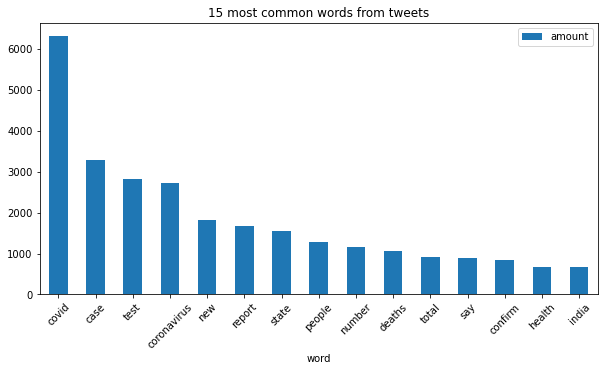

In [181]:
amnt_plot = word_amnts[:15].plot.bar(x='word', y='amount', figsize=(10,5), title='15 most common words from tweets')
plt.xticks(ticks=np.arange(15), labels=word_amnts['word'][:15], rotation=45)

**TF-IDFs for dataset**

([<matplotlib.axis.XTick at 0x7f91c5a2e650>,
 [Text(0, 0, 'death'),
  Text(1, 0, 'explicable'),
  Text(2, 0, 'discrepancies'),
  Text(3, 0, 'roughly'),
  Text(4, 0, 'small'),
  Text(5, 0, 'general'),
  Text(6, 0, 'toll'),
  Text(7, 0, 'count'),
  Text(8, 0, 'different'),
  Text(9, 0, 'source')])

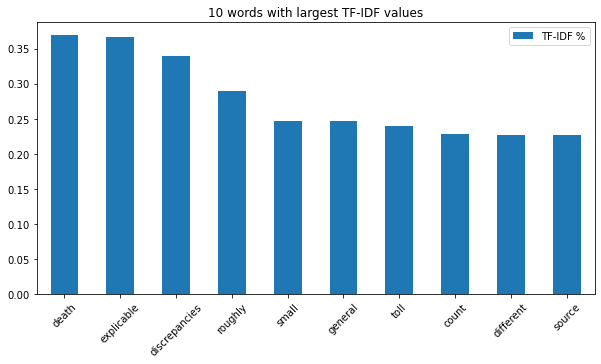

In [182]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(all_clean)
tfIdf_df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=['TF-IDF %'])
tfIdf_df['word'] = tfIdfVectorizer.get_feature_names()
tfIdf_df = tfIdf_df.sort_values('TF-IDF %', ascending=False)
tfIdf_df[:10].plot.bar(figsize=(10,5), title='10 words with largest TF-IDF values')
plt.xticks(ticks=np.arange(10), labels=tfIdf_df['word'][:10], rotation=45)

**Tweets' lenghts in words**

Text(0.5, 0, 'Word count in tweet')

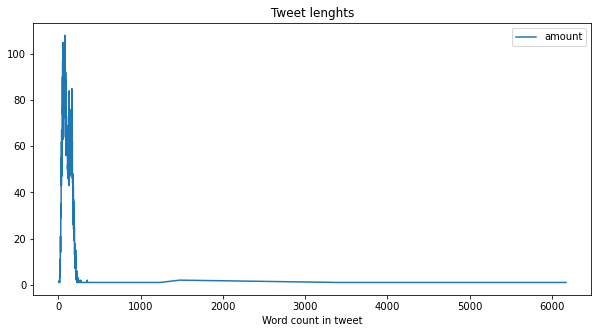

In [183]:
tweet_lens = {}

for tweet in all_clean:
    length = len(tweet)
    if length in tweet_lens.keys():
        tweet_lens[length] += 1
    else:
        tweet_lens[length] = 1

tweet_lens_df = pd.DataFrame.from_dict(tweet_lens, orient='index', columns=['amount'])
tweet_lens_df = tweet_lens_df.sort_index()
tweet_lens_df.plot(figsize=(10,5), title='Tweet lenghts')
plt.xlabel('Word count in tweet')

Text(0.5, 0, 'Word count in tweet')

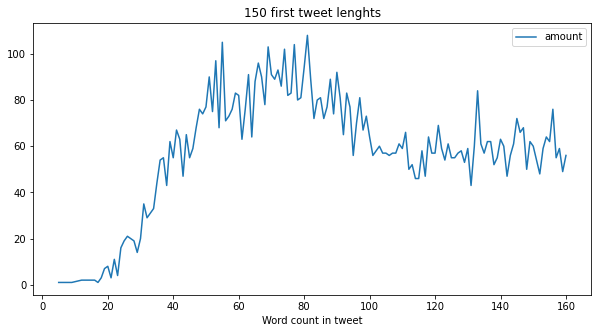

In [184]:
tweet_lens_df[:150].plot(figsize=(10,5), title='150 first tweet lenghts')
plt.xlabel('Word count in tweet')

**Insight to bigrams, a bigram consists out of two words that occur succesively in the text**

Text(0.5, 0, 'Bigrams')

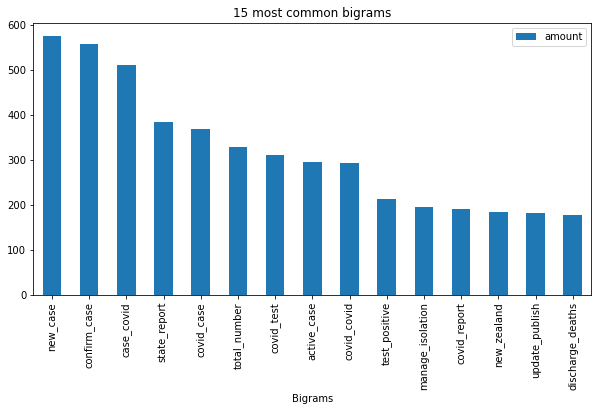

In [185]:
bigrams_all = {}
bigrams_freq = []

for tweet in all_clean:
    bgs = ngrams(tweet.split(), 2)

    for bg in bgs:
        bigrams_freq.append(bg)
        bg = str(bg[0]) + "_" + str(bg[1])
        if bg not in bigrams_all.keys():
            bigrams_all[bg] = 1
        else:
            bigrams_all[bg] += 1

bigrams_all_df = pd.DataFrame.from_dict(bigrams_all, orient='index', columns=['amount'])
bigrams_all_df = bigrams_all_df.astype({'amount':'int32'})
bigrams_all_df['bigrams'] = bigrams_all_df.index
bigrams_all_df = bigrams_all_df.sort_values(by='amount', axis=0, ascending=False)
bigrams_all_df[:15].plot.bar(figsize=(10,5), title='15 most common bigrams')
plt.xticks(ticks=np.arange(15), labels=bigrams_all_df['bigrams'][:15], rotation=90)
plt.xlabel('Bigrams')

## Generating the model

In [223]:
size = len(tokenizer.word_index) + 1
tf.keras.backend.clear_session()

epoch = 3   # Number of runs through the data
batchSize = 32  # The number of items in each batch
outputDimensions = 16   # The size of the output
units = 256 # Dimensions of the output space

model = tf.keras.Sequential([ #Start the sequential model, doing one layer after another in a sequence
    L.Embedding(size, outputDimensions, input_length = texts_train.shape[1]), #Embed the model with the number of words and size
    L.Bidirectional(L.LSTM(units, return_sequences = True)), #Make it so the model looks both forward and backward at the data
    L.GlobalMaxPool1D(), #Take the max values over time
    L.Dropout(0.3), #Make the dropout 0.3, making about a third 0 to prevent overfitting
    L.Dense(64, activation="relu"), #Create a large dense layer
    L.Dropout(0.3), #Make the dropout 0.3, making about a third 0 to prevent overfitting
    L.Dense(3) #Create a small dense layer
])


model.compile(loss = SparseCategoricalCrossentropy(from_logits = True), #Compile the model with a SparseCategorical loss function
              optimizer = 'adam', metrics = ['accuracy'] #Add an adam optimizer and collect the accuracy along the way
             )

history = model.fit(texts_train, train_df['is_real'], epochs = epoch, validation_split = 0, batch_size = batchSize) #Fit the model to the data

Epoch 1/3
6420/6420 [==============================] - 1282s 200ms/sample - loss: 0.4882 - acc: 0.7636
Epoch 2/3
6420/6420 [==============================] - 1147s 179ms/sample - loss: 0.1886 - acc: 0.9375
Epoch 3/3
6420/6420 [==============================] - 1274s 198ms/sample - loss: 0.0928 - acc: 0.9721


**Validation data**

In [224]:
predict = model.predict_classes(texts_val) #Predict ratings based on the model
loss, accuracy = model.evaluate(texts_val, val_df["is_real"]) #Get the loss and Accuracy based on the tests

#Print the loss and accuracy
print("Validation Loss: ", loss)
print("Validation Accuracy: ", accuracy)

2140/2140 [==============================] - 51s 24ms/sample - loss: 0.2732 - acc: 0.9117
Validation Loss:  0.273237350736266
Validation Accuracy:  0.91168225


In [225]:
pd.set_option("display.max_colwidth", 1000) #Show as much of the tweet as possible

validLabel = val_df["is_real"].copy() #Get the encoded labels (1 for real, 0 for fake)
validLabel = pd.DataFrame(validLabel) #Convert to a dataframe to hold more data
validLabel["predictions"] = predict #Add the predictions to the dataframe
validLabel["tweet"] = val_df["tweet"].copy() #Add the original tweet for comparison sake
validLabel #Compare

,is_real,predictions,tweet
0,0,0,Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country
1,0,0,11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.
2,0,0,"COVID-19 Is Caused By A Bacterium, Not Virus And Can Be Treated With Aspirin"
3,0,0,Mike Pence in RNC speech praises Donald Trump’s COVID-19 “seamless” partnership with governors and leaves out the president's state feuds: https://t.co/qJ6hSewtgB #RNC2020 https://t.co/OFoeRZDfyY
4,1,1,6/10 Sky's @EdConwaySky explains the latest #COVID19 data and government announcement. Get more on the #coronavirus data here👇 https://t.co/jvGZlSbFjH https://t.co/PygSKXesBg
...,...,...,...
2135,0,0,Donald Trump wrongly claimed that New Zealand had a “big surge” in COVID-19 cases on a day when the country reported nine new cases. The U.S. has reported more than 50000 new cases per day for most of July and August. https://t.co/y3QsWUj23I
2136,1,1,Current understanding is #COVID19 spreads mostly from person to person through respiratory droplets produced when a person coughs or sneezes similar to how flu spreads. Learn more at https://t.co/VvIzx7O3mM https://t.co/MiHHHyCfTa
2137,0,0,Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h
2138,0,0,Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj


In [262]:
validLabel.loc[(validLabel['is_real'] != validLabel['predictions'])]

,is_real,predictions,tweet
10,1,0,You can still fly the friendly skies without fear of COVID if airlines stay serious about safety. https://t.co/H8mGjwDl7G #coronavirus
13,1,0,Tomorrow April 6 we will pass 10000 coronavirus deaths. We passed 5000 on April 2. We passed 1000 on March 26. We passed 100 on March 18.
17,0,1,"Gov. Andrew Cuomo “was simply saying if we can share 20 percent of your excess your non-used ventilators to help people in other parts of the state on a voluntary basis that would be great. Of course there was a reaction to that which was not positive."""
25,1,0,Breathlessness excessive fatigue and muscle aches from COVID can last for months. https://t.co/OUhBRirKpE
40,1,0,EMA endorses the use of dexamethasone for COVID-19. https://t.co/RKPH74Hz3W
...,...,...,...
2094,0,1,“The winner of this debate shall be he who can swallow this vial of COVID-19...and survive” whispers grinning Lester Holt #DemocraticDebate #coronavirus https://t.co/foFI87QZ2h
2103,0,1,Victoria has received a lot of attention for extending its state of emergency. But it's the only state which needs to go to Parliament to do so. Other states have been quietly extending theirs with no parliamentary scrutiny: https://t.co/ljSZwObpsR #auspol #coronavirusFacts https://t.co/jDWBWgxp4E
2104,0,1,From June 26 Taipei Veterans General Hospital implements strict access control including a ban on patients visits. The local transmission in Taiwan is worse than what the Taiwan health ministry reported.
2107,1,0,ICYMI: Deborah Birx 3/8/20 White House Briefing: “I know many of you are watching the [Covid] Act Now model and the IHME model from — and they have consistently decreased the number...That is modeled on what America is doing. That’s what’s happening.” https://t.co/IDhKGPjgWB


In [261]:
predict = model.predict_classes(texts_test)

pd.set_option("display.max_colwidth", 1000) #Show as much of the tweet as possible
test_label = pd.DataFrame() #Convert to a dataframe to hold more data
test_label["is_real"] = predict #Add the predictions to the dataframe
test_label["tweet"] = test_df["tweet"].copy() #Add the original tweet for comparison sake
tweet_preds_df.to_csv(csv_path + '/modified_datasets/test_with_preds.csv')
test_label.head() #Compare

,is_real,tweet
0,1,Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht
1,0,Alfalfa is the only cure for COVID-19.
2,0,President Trump Asked What He Would Do If He Were To Catch The Coronavirus https://t.co/3MEWhusRZI #donaldtrump #coronavirus
3,1,States reported 630 deaths. We are still seeing a solid national decline. Death reporting lags approximately 28 days from symptom onset according to CDC models that consider lags in symptoms time in hospital and the death reporting process. https://t.co/LBmcot3h9a
4,1,This is the sixth time a global health emergency has been declared under the International Health Regulations but it is easily the most severe-@DrTedros https://t.co/JvKC0PTett


## Predict realness of random Covid19-tweets

In [256]:
tweet_preds = model.predict_classes(texts_tweets)
tweet_preds = ['real' if pred == 1 else 'false' for pred in tweet_preds] # Un-dummy label

In [257]:
tweet_preds_df = tweet_df["text"].copy() # Get the original tweets
tweet_preds_df = pd.DataFrame(tweet_preds_df)
tweet_preds_df["prediction"] = tweet_preds
tweet_preds_df = tweet_preds_df[["prediction", "text"]]
tweet_preds_df.to_csv(csv_path + '/modified_datasets/tweets_with_preds.csv')
tweet_preds_df.head() #Show the tests

,prediction,text
0,real,"Chandigarh reports 431 new #COVID19 cases, taking the total number of cases to 33,309"
1,false,"Cold, Sunny, and Pandemically Affected https://t.co/t2MOIJurLn. Cannot wait to be able to spend more time outside. #confinement #covid19 #coronavirus"
2,false,Jammu and Kashmir reports 1145 new #COVID19 positive cases; 503 from Jammu division and 642 from Kashmir division.\n\nTotal positive cases: 145166\nTotal discharges: 132205\nDeaths: 2051\nActive cases: 10910 https://t.co/4WRbf2ncgZ
3,real,#Goa reports 762 new #COVID19 positive cases and 4 deaths\n\nNumber of active cases stand at 6643.
4,real,"Ostriches of @Andaman_Admin report 1 more death &amp; 42 more people #COVID19 positive, 31 contacts; 11 flyers, Saturday. Discharge 36, total 5331, Dead 64, active 121.\n \nContinue to mislead people by describing recovered patients as ""total CURED 5146"".\n\n• Hawk Eye\nPort Blair"
